In [32]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.animation import FuncAnimation

In [33]:
def print_datarange(data):
    # data range: 
    print("x: ", np.min(data[:, :, 0]), np.max(data[:, :, 0]))
    print("y: ", np.min(data[:, :, 1]), np.max(data[:, :, 1]))

In [34]:
def plot_single_frame_data(frame_data: np.ndarray, ax: Axes = None): 
    if ax is None:
        # Create a new figure and 2D axes
        fig, ax = plt.subplots()
    
    nr_skeleton_pnts = frame_data.shape[0]
    if nr_skeleton_pnts == 24:  # 3 tail points
        nr_tail = 3
        last_segment_to_head = [-4, 0]

    elif nr_skeleton_pnts == 22:  # 2 tail points. 
        nr_tail = 1
        last_segment_to_head = [-2, 0]
    
    scatter_colors = ["red"] + ["black"] * 20 + ["yellow"] * nr_tail  # red: head, white: body, yellow: tail.
    ax.scatter(x=frame_data[:, 0], y=frame_data[:, 1], c=scatter_colors)
    ax.plot(frame_data[:-nr_tail, 0], frame_data[:-nr_tail, 1], c="black")  # body curve
    ax.plot(frame_data[last_segment_to_head, 0], frame_data[last_segment_to_head, 1], c="black")
    ax.plot(frame_data[[11, -1], 0], frame_data[[11, -1], 1], c="black")
    ax.plot(frame_data[[10, -1], 0], frame_data[[10, -1], 1], c="black")
    
    
def plot_larvee(frame: int, data: np.ndarray, ax: Axes = None):
    """Plot one frame of larvee data.
    
    
    """
    if ax is None:
        # Create a new figure and 2D axes
        fig, ax = plt.subplots()
    
    frame_data = data[frame, :, :]
    
    ax.clear()
    plot_single_frame_data(frame_data, ax=ax)
    ax.set_xlim(np.min(data[:, :, 0]), np.max(data[:, :, 0]))
    ax.set_ylim(np.min(data[:, :, 1]), np.max(data[:, :, 1]))    
    ax.set_title(f"{frame=}")


def animate_and_save(data: np.ndarray,
                     file_name: str, 
                     num_frames: int = 100,
                     interval: float = 1000/5, 
                     fps: int = 10):

    fig, ax = plt.subplots()
    # Set any additional parameters for your plot or axes if needed
    
    # Create the animation
    animation = FuncAnimation(fig, plot_larvee, frames=num_frames, fargs=(data, ax), interval=interval)
    
    # If you want to save the animation as a GIF, uncomment the following line
    animation.save(file_name,  fps=fps)

# 0. Load data

In [4]:
centered_data_v2_name = "centered/video2_centered.npy"
centered_data_v3_name = "centered/video3_centered.npy"

centered_data_v2 = np.load(centered_data_v2_name)
centered_data_v3 = np.load(centered_data_v3_name)

cent_data_dict = {"pos_v2": centered_data_v2,
                  "pos_v3": centered_data_v3}

for k, v in cent_data_dict.items():
    print(k, v.shape)

pos_v2 (1938, 22, 2)
pos_v3 (2999, 22, 2)


In [18]:
# Data range and pre-processing: 

data_use = cent_data_dict["pos_v3"]

# data range: 
print_datarange(data_use)

# reshape data: 
data_reshaped = data_use.reshape((data_use.shape[0], 44))
print(f"{data_reshaped.shape=}")

# get data tensor: 
# 1. Define autoencoder:
data_tensor = torch.tensor(data_reshaped, dtype=torch.float32)
print(f"{data_tensor.shape=}")

x:  -556.4913711547852 559.0387247258967
y:  -558.3627458052201 563.8299005681819
data_reshaped.shape=(2999, 44)
data_tensor.shape=torch.Size([2999, 44])


# 1. Train autoencoder:

In [36]:
# Define the autoencoder architecture

class Autoencoder(nn.Module):
    def __init__(self, input_size):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8)
        )
        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, input_size),
            # nn.Sigmoid()  # Sigmoid activation to squash output between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [41]:
# Setup: 

# Hyperparameters
batch_size = 128
learning_rate = 0.001
epochs = 1000

# Create a DataLoader for the NumPy array
dataset = TensorDataset(data_tensor)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize the model, loss function, and optimizer
model = Autoencoder(input_size=data_reshaped.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [42]:
# Training loop
for epoch in range(epochs):
    for data in data_loader:
        input_data, = data
        optimizer.zero_grad()
        outputs = model(input_data)
        loss = criterion(outputs, input_data)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [1/1000], Loss: 40557.8711
Epoch [2/1000], Loss: 29010.1680
Epoch [3/1000], Loss: 12294.9678
Epoch [4/1000], Loss: 2703.7957
Epoch [5/1000], Loss: 1490.4751
Epoch [6/1000], Loss: 1403.9680
Epoch [7/1000], Loss: 942.0372
Epoch [8/1000], Loss: 1257.2590
Epoch [9/1000], Loss: 873.5072
Epoch [10/1000], Loss: 1155.2924
Epoch [11/1000], Loss: 1862.2880
Epoch [12/1000], Loss: 1122.2711
Epoch [13/1000], Loss: 1261.0608
Epoch [14/1000], Loss: 737.1241
Epoch [15/1000], Loss: 1230.5580
Epoch [16/1000], Loss: 1021.3051
Epoch [17/1000], Loss: 905.1285
Epoch [18/1000], Loss: 1254.2146
Epoch [19/1000], Loss: 989.3922
Epoch [20/1000], Loss: 797.5242
Epoch [21/1000], Loss: 1031.4055
Epoch [22/1000], Loss: 1589.1307
Epoch [23/1000], Loss: 1147.9624
Epoch [24/1000], Loss: 714.3237
Epoch [25/1000], Loss: 818.0402
Epoch [26/1000], Loss: 898.4511
Epoch [27/1000], Loss: 1180.8698
Epoch [28/1000], Loss: 1411.1608
Epoch [29/1000], Loss: 723.6180
Epoch [30/1000], Loss: 937.3026
Epoch [31/1000], Loss: 1015

In [43]:
# Reconstruction error on training data:  
# print(data_tensor.size)
test_data = data_tensor
reconstruction = model(test_data)
larvee_recon = reconstruction.detach().numpy().reshape((test_data.shape[0], 22, 2))
print(f"{larvee_recon.shape=}")

larvee_recon.shape=(2999, 22, 2)


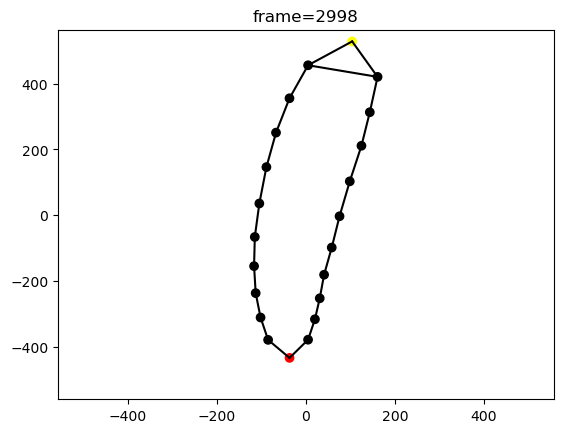

In [45]:
# plot animation: 
animate_and_save(data=larvee_recon, 
                 file_name=f"autoencoder_reconstruction/autoencoder_reconstruction.gif", 
                 num_frames=larvee_recon.shape[0])

latent_space.shape=(2999, 8)


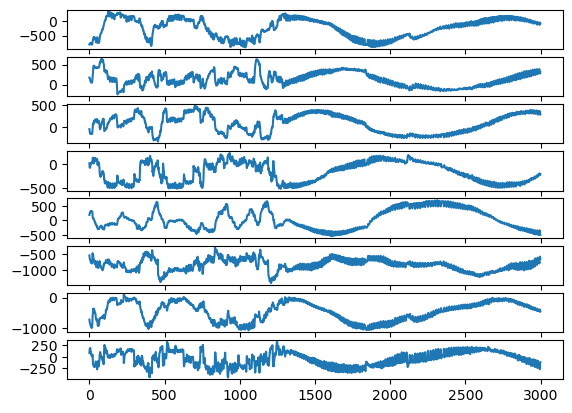

In [49]:
# Visualize latent space: 

latent_space = model.encoder(data_tensor).detach().numpy()

print(f"{latent_space.shape=}")

fig, axs = plt.subplots(nrows=8, ncols=1)
for i_ax, ax in enumerate(axs):
    ax.plot(latent_space[:, i_ax])

# 2. Maximally predictive states on autoencoder

In [46]:
import deeptime as dtime
from sklearn.cluster import MiniBatchKMeans, KMeans
import scipy

from utils_dennis.maximally_predictive_states import (time_delay_embedding, 
                                                      cluster_data, 
                                                      compare_time_series, 
                                                      get_entropy
                                                      )

#### 2.1 Timedelay-embedding + clustering

In [58]:
X = latent_space

delay = 4
n_clusters = 500

traj_matrix = time_delay_embedding(data=X, delay=delay)
print(f"{traj_matrix.shape=}")

labels, centers, kmeans_model = cluster_data(data=traj_matrix,
                                             n_clusters=n_clusters,
                                             random_state=1,
                                             algorithm="minibatchkmeans")
print(f"{labels.shape=}")
print(f"{centers.shape=}")

print(f"Delay = {delay} = {delay/5} seconds.")

traj_matrix.shape=(2995, 40)
labels.shape=(2995,)
centers.shape=(500, 40)
Delay = 4 = 0.8 seconds.


traj_matrix_reconstructed.shape=(2995, 40)


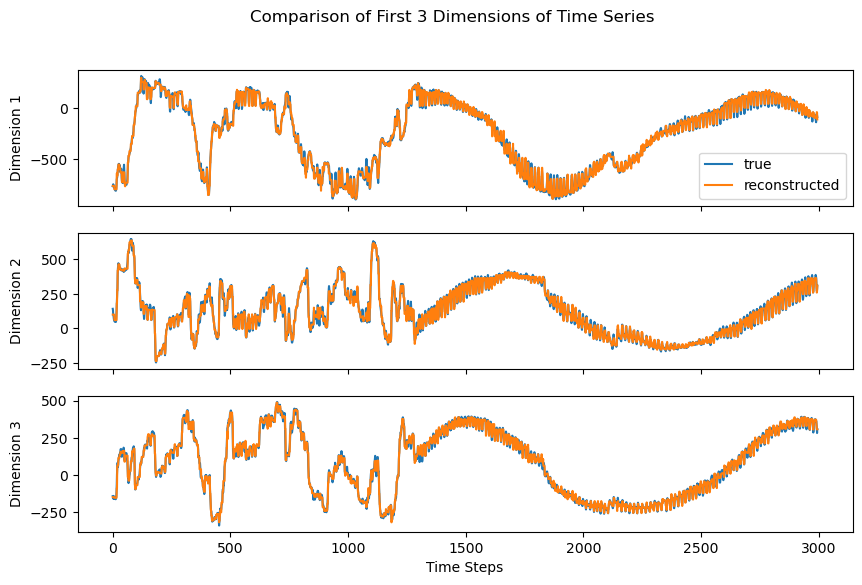

In [59]:
# reconstruct timeseries: 
traj_matrix_reconstructed = centers[labels, :]
print(f"{traj_matrix_reconstructed.shape=}")

# plot reconstruction: 
compare_time_series(traj_matrix[:, :], traj_matrix_reconstructed[:, :], k=3,
                    label1="true", label2="reconstructed")

#### 2.2 Create transition matrix with deeptime: 

Text(0, 0.5, 'states')

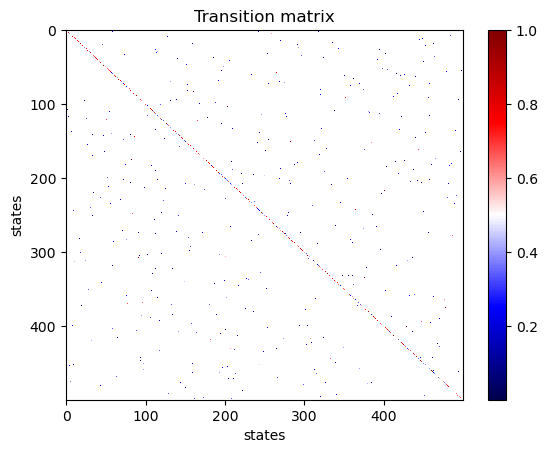

In [60]:
lag = 1

# count matrix: 
C = dtime.markov.tools.estimation.count_matrix(labels,
                                               lag=lag,
                                               sliding=True)

P = dtime.markov.tools.estimation.transition_matrix(C, reversible=False)

cmap = plt.get_cmap('seismic')  # You can choose any other colormap
cmap.set_under('white')
plt.imshow(P.toarray(), cmap=cmap, interpolation='nearest', aspect='auto', vmin=0.0001,
           vmax=1)
plt.colorbar()
plt.title("Transition matrix")
plt.xlabel("states")
plt.ylabel("states")

#### 2.3 Sample Markov model

In [71]:
msm = dtime.markov.msm.MarkovStateModel(P)

start_time = 400

start_state_real_space = traj_matrix[[start_time], :]
print(f"{start_state_real_space.shape=}")
start_state_discrete = kmeans_model.predict(start_state_real_space)
print(f"{start_state_discrete.shape=}")

n_steps = 1000
simulated_labels = msm.simulate(n_steps=n_steps, start=start_state_discrete, dt=1,
                                seed=1)
print(f"{simulated_labels.shape=}")

simulated_latent_space_delay = centers[simulated_labels]
print(f"{simulated_latent_space_delay.shape=}")

start_state_real_space.shape=(1, 40)
start_state_discrete.shape=(1,)
simulated_labels.shape=(1000,)
simulated_latent_space_delay.shape=(1000, 40)


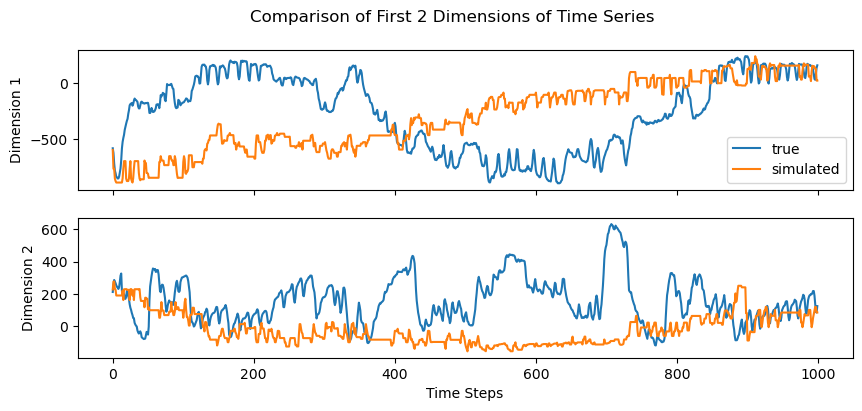

In [72]:
# plot reconstruction: 
time_window = 1000

compare_time_series(traj_matrix[start_time:start_time + time_window, :],
                    simulated_latent_space_delay[:time_window, :], k=2, label1="true",
                    label2="simulated")

In [76]:
simulated_latent_space_nodelay = simulated_latent_space_delay[:, :8]
print(f"{simulated_latent_space_nodelay.shape=}")

# simualted real space: 
latent_tensor = torch.tensor(simulated_latent_space_nodelay, dtype=torch.float32)
reconstructed_markov = model.decoder(latent_tensor).detach().numpy().reshape((latent_tensor.shape[0], 22, 2))
print(f"{reconstructed_markov.shape=}")

simulated_latent_space_nodelay.shape=(1000, 8)
reconstructed_markov.shape=(1000, 22, 2)


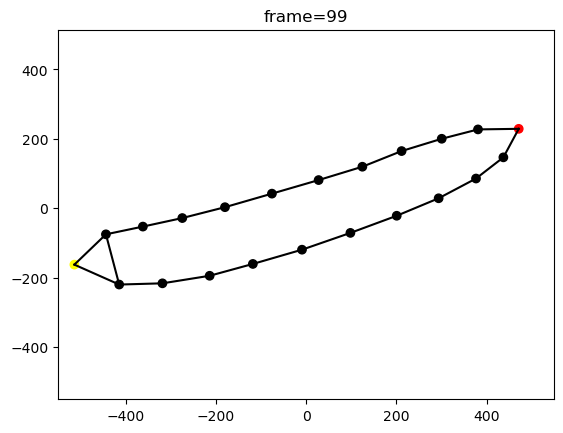

In [77]:
# Markov simulation: 

#calculate fps: 
# fps = int(10/lag)

animate_and_save(data=reconstructed_markov, 
                 file_name=f"autoencoder_reconstruction/markov_larvee_ae_v3.gif")

#### 2.4. Entropy sweep

In [78]:
# Calculate entropy for various delays and number of clusters. 
lag_use = 1

delay_list = np.arange(2, 15, 2, dtype=int)
n_clusters_list = np.array(np.logspace(2, 3, 4), dtype=int)
# n_clusters_list = np.array([100, 200, 500, 1000, 1500], dtype=int)
entropy_data = np.zeros((len(delay_list), len(n_clusters_list)))
for i_delay, delay in enumerate(delay_list):
    traj_matrix_use = time_delay_embedding(data=X, delay=delay)
    for i_n_clusters, n_clusters in enumerate(n_clusters_list):
        labels_use, _, _ = cluster_data(data=traj_matrix_use, n_clusters=n_clusters,
                                        random_state=1, algorithm="minibatchkmeans")
        C_use = dtime.markov.tools.estimation.count_matrix(labels_use,
                                                           lag=lag_use,
                                                           sliding=True)
        C_use = dtime.markov.tools.estimation.largest_connected_submatrix(C_use, directed=True)
        print(f"{C_use.shape=}")
        connected_bool = dtime.markov.tools.analysis.is_connected(C_use, directed=True)
        print(f"{connected_bool=}")
        P_use = dtime.markov.tools.estimation.transition_matrix(C_use, reversible=False)
        entropy = get_entropy(P_use)
        entropy_data[i_delay, i_n_clusters] = entropy
        print(f"Computed for {delay} delays and {n_clusters} clusters. entropy={entropy:.3f}\n")

C_use.shape=(99, 99)
connected_bool=True
Computed for 2 delays and 100 clusters. entropy=0.611
C_use.shape=(212, 212)
connected_bool=True
Computed for 2 delays and 215 clusters. entropy=0.703
C_use.shape=(462, 462)
connected_bool=True
Computed for 2 delays and 464 clusters. entropy=0.723
C_use.shape=(990, 990)
connected_bool=True
Computed for 2 delays and 1000 clusters. entropy=0.585

C_use.shape=(99, 99)
connected_bool=True
Computed for 4 delays and 100 clusters. entropy=0.601
C_use.shape=(213, 213)
connected_bool=True
Computed for 4 delays and 215 clusters. entropy=0.695
C_use.shape=(429, 429)
connected_bool=True
Computed for 4 delays and 464 clusters. entropy=0.755
C_use.shape=(993, 993)
connected_bool=True
Computed for 4 delays and 1000 clusters. entropy=0.614

C_use.shape=(98, 98)
connected_bool=True
Computed for 6 delays and 100 clusters. entropy=0.531
C_use.shape=(212, 212)
connected_bool=True
Computed for 6 delays and 215 clusters. entropy=0.697
C_use.shape=(451, 451)
connected

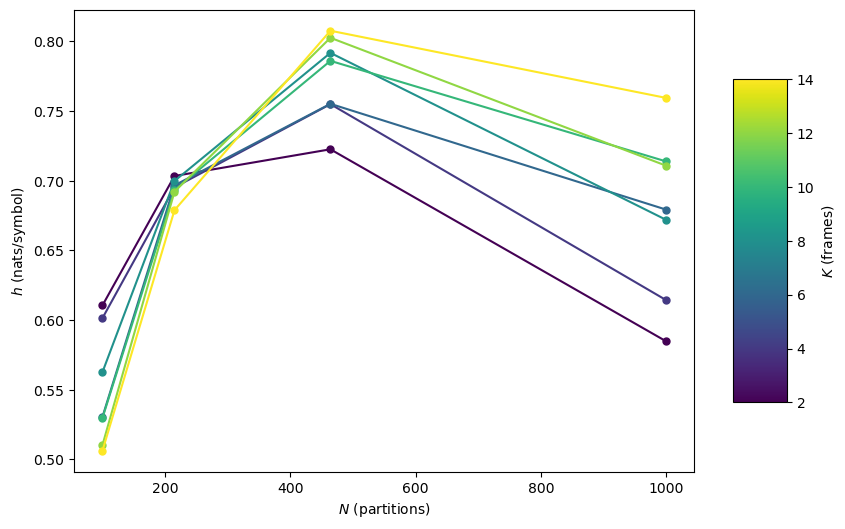

delay_list=array([ 2,  4,  6,  8, 10, 12, 14])
n_clusters_list=array([ 100,  215,  464, 1000])
max_h_K=array([0.72260056, 0.75500953, 0.75523855, 0.79181899, 0.7860808 ,
       0.80263989, 0.80771041])


In [79]:
# lot entropy vs n_clusters and delays. 
colors_K = plt.cm.viridis(np.linspace(0, 1, len(delay_list)))
max_h_K = np.zeros(len(delay_list))
cil_h_K = np.zeros(len(delay_list))
ciu_h_K = np.zeros(len(delay_list))
max_idx_array = np.zeros(len(delay_list), dtype=int)
plt.figure(figsize=(10, 6))

for k in range(len(delay_list)):
    plt.errorbar(n_clusters_list, entropy_data[k], c=colors_K[int(k)], capsize=4,
                 marker='o', ms=5)
    max_idx = np.argmax(entropy_data[k])
    max_idx_array[k] = int(max_idx)
    max_h_K[k] = entropy_data[k][max_idx]

plt.scatter(n_clusters_list, entropy_data[k], c=entropy_data[k], vmin=min(delay_list),
            vmax=max(delay_list), s=0)
plt.colorbar(shrink=.7, aspect=6, label='$K$ (frames)')
plt.xlabel('$N$ (partitions)')
plt.ylabel('$h$ (nats/symbol)')
#plt.xscale('log')
plt.show()

print(f"{delay_list=}")
print(f"{n_clusters_list=}")
print(f"{max_h_K=}")